In [54]:
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

Function to simulate the vibrating string using euler step for the first time step and finite difference method for further evolution.\
**Boundary conditions**: $\psi(x = 0, t)$ = 0 and $\psi(x = L,t)$ = 0.

In [56]:
def simulate_vibrating_string(c, L, T, dt, dx, dphi_dx, x_0):
    """
    Simulate the vibrating string with the given parameters.
    param x_0: The initial displacement of the string.
    param c: The wave speed.
    param L: The length of the string.
    param T: The total time to simulate.
    param dt: The time step.
    param dx: The space step.    
    """ 
    time_steps = np.arange(0, T+dt, dt)
    x = np.zeros((len(x_0), len(time_steps)), dtype=float) # Create an array to store the results.
    x[:,0] = x_0
    # euler step to find the next time step.
    x[1:-1,1] = x_0[1:-1] + c * dt * dphi_dx[1:-1]

    for j in range(2, len(time_steps)):
        x[1:-1, j] = 2*x[1:-1, j-1] - x[1:-1, j-2] + c**2 * (dt/dx)**2 * (x[2:, j-1] + x[0:-2, j-1] - 2*x[1:-1,j-1])

    return x
    

#### Test run

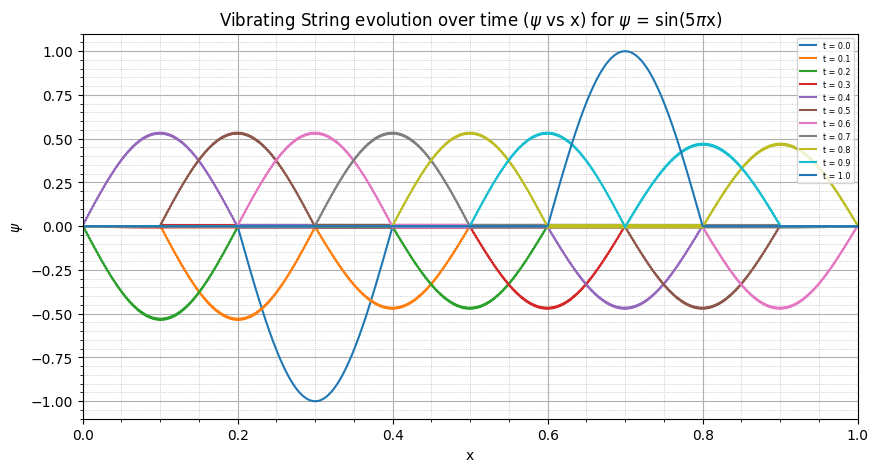

In [71]:
# define the parameters
c = 1
L = 1
T = 1
dt = 0.001
N = 1000
dx = L/N

# define the wave equation.

n = 5 # 'n' in wave equation sin(n*pi*x)
#x_0 = np.sin(n * np.pi * np.arange(0, L, dx))
x_0 = np.array([np.sin(n * np.pi * x) if 1/5 < x < 2/5 else 0 for x in np.arange(0, L+dx, dx)])
dphi_dx = np.array([np.cos(n * np.pi * x) if 1/5 < x < 2/5 else 0 for x in np.arange(0, L+dx, dx)])
#dphi_dx = np.cos(n * np.pi * np.arange(0, L, dx))

# run simulation
x = simulate_vibrating_string(c, L, T, dt, dx, dphi_dx, x_0)

# Plotting
plt.figure(figsize=(10, 5))
for i,t in enumerate(np.arange(0, T+dt, dt)):
    if i % 100 == 0:
        plt.plot(np.arange(0, L+dx, dx),x[:,i], label='t = {}'.format(round(t,3)))
plt.xlabel('x')
plt.ylabel(r'$\psi$')
plt.title(fr'Vibrating String evolution over time ($\psi$ vs x) for $\psi$ = sin({n}$\pi$x)')
plt.xlim(0, L)
plt.legend(loc = 'upper right', fontsize='xx-small')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

#### Animation

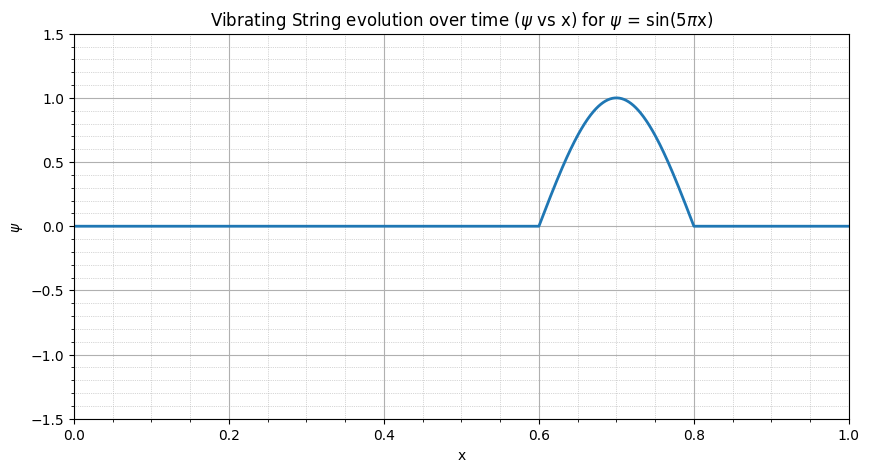

In [72]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, L)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('x')
ax.set_ylabel(r'$\psi$')
ax.set_title(fr'Vibrating String evolution over time ($\psi$ vs x) for $\psi$ = sin({n}$\pi$x)')
ax.grid(True)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5')

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function: this is called sequentially
def animate(i):
    y = x[:, i]
    line.set_data(np.arange(0, L+dx, dx), y)
    return line,

# Call the animator
ani = FuncAnimation(fig, animate, init_func=init, frames=len(np.arange(0, T+dt, dt)), interval=20, blit=True)

# To save the animation, uncomment the following line
#ani.save('string_vibration.mp4', writer='ffmpeg')
ani.save('string_vibration.gif', writer=PillowWriter(fps=20))

plt.show()


#### Experiments

#### Uniqueness and stability

#### 2-D diffusion

In [73]:
def simulate_2D_diffusion(D, L, T, dt, dx, x_0):
    """
    Simulate the 2D diffusion with the given parameters.
    param D: The diffusion coefficient.
    param L: The length of the domain.
    param T: The total time to simulate.
    param dt: The time step.
    param dx: The space step.
    param x_0: The initial concentration.    
    """
    if ((4 * dt * D) / (dx**2)) > 1:
        print((4 * dt * D) / (dx**2))
        raise ValueError("The given parameters will result in an unstable solution. Please use a smaller time step or a larger space step.")
    time_steps = np.arange(0, T+dt, dt)
    x = np.zeros((len(x_0), len(x_0), len(time_steps)), dtype=float) # Create an array to store the results.
    x[:,-1,:] = 1 # Set the boundary condition.
    x[:,:,0] = x_0 # Set the initial condition.
    # Assuming the concentration is uniform in the x direction.
    for k in range(1, len(time_steps)):
        x[:, 1:-1, k] = x[:, 1:-1, k-1] + ((D * dt) / (dx**2)) * (x[:, 1:-1, k-1] + x[:, 1:-1, k-1] + x[:, 2:, k-1] + x[:, 0:-2, k-1] - 4*x[:, 1:-1, k-1])

    return x


#### Test run

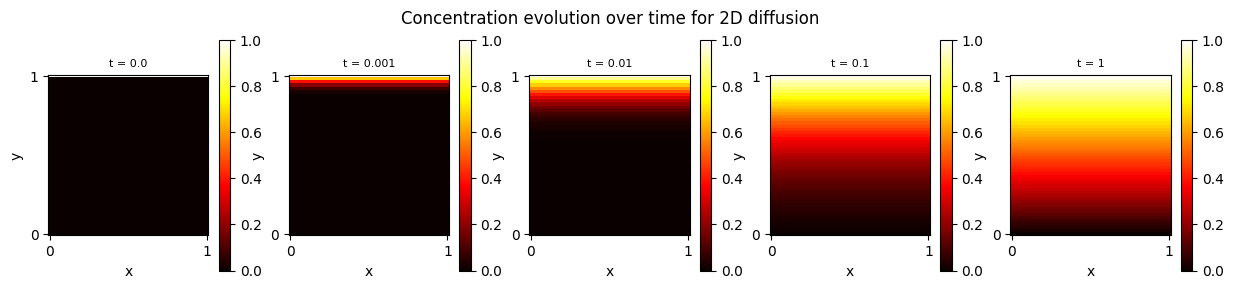

In [74]:
# define the parameters
D = 1
L = 1
T = 1
dt = 0.0001
N = 50
dx = L/N
x_0 = np.zeros((N+1, N+1), dtype=float)
x_0[:, -1] = 1

x = simulate_2D_diffusion(D, L, T, dt, dx, x_0)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(15, 3))
for i,t in enumerate([0.0, 0.001, 0.01, 0.1, 1]):
    im = ax[i].imshow(x[:,:,int(t*10000)].T, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=ax[i])
    #fig.colorbar(im, ax=ax[i], label='Concentration'
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_xticks([0, N], ['0', str(L)])
    ax[i].set_yticks([0, N], ['0', str(L)])
    ax[i].set_title('t = {}'.format(t), fontsize=8)

fig.suptitle('Concentration evolution over time for 2D diffusion', fontsize=12)
plt.show()


#### Comparison with Analytical solution.

In [75]:
def diffusion_2d_analytical(y, t, D, num_terms):
    # can use a stopping criteria to implemnt this.
    """
    Calculate the series solution for the concentration c(y, t).
    param y: position of y coordinate.
    param t: time.
    param D: diffusion coefficient.
    param num_terms : number of terms included in the infinite sum.
    """
    terms = [(erfc((1 - y + 2*i) / (2 * np.sqrt(D * t))) - 
              erfc((1 + y + 2*i) / (2 * np.sqrt(D * t)))) for i in range(num_terms)]
    return sum(terms)

Text(0.5, 1.0, 'Comparision of Analytical and simulated solutions for 2D diffusion')

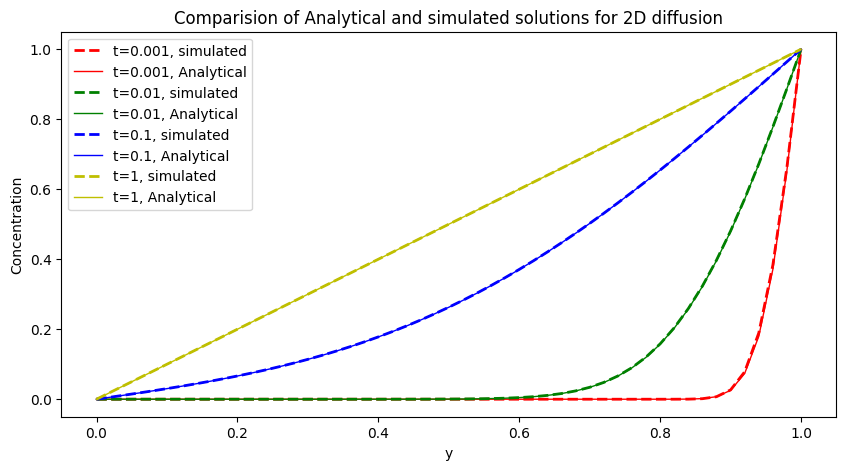

In [85]:
plt.figure(figsize=(10, 5))
colors = ['r', 'g', 'b', 'y']
for i,t in enumerate([0.001, 0.01, 0.1, 1]):
    color = colors[i]
    plt.plot(np.arange(0, L+dx, dx), x[0,:,int(t*10000)], linestyle = '--', label = f't={t}, simulated',color=color, linewidth=2)
    plt.plot(np.arange(0, L+dx, dx), diffusion_2d_analytical(np.arange(0, L+dx, dx), t, D, 1000), label = f't={t}, Analytical', color=color, linewidth=1)

plt.legend()
plt.ylabel('Concentration')
plt.xlabel('y')
plt.title('Comparision of Analytical and simulated solutions for 2D diffusion')

#### Animation

ValueError: quantization error

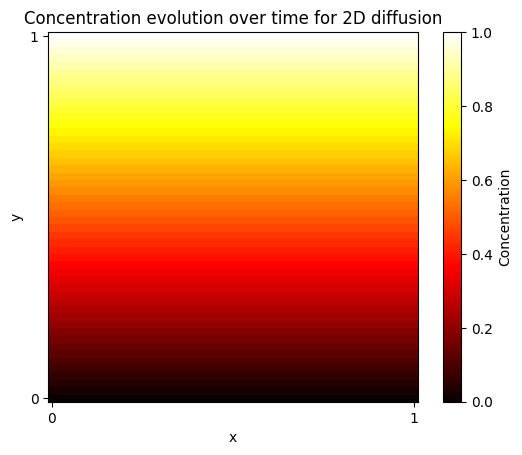

In [84]:
# Set up the figure
fig, ax = plt.subplots()
cax = ax.imshow(x[:, :, 0].T, cmap='hot', interpolation='nearest', origin='lower')
fig.colorbar(cax, label='Concentration')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks([0, N-1], ['0', str(L)])
ax.set_yticks([0, N-1], ['0', str(L)])
ax.set_title('Concentration evolution over time for 2D diffusion')

# Initialization function for FuncAnimation
def init():
    cax.set_data(np.zeros((L, L)).T)
    return cax,

# Animation function that FuncAnimation will call
def animate(i):
    cax.set_data(x[:, :, i].T)
    return cax,

# Create the animation object
ani = FuncAnimation(fig, animate, frames=x.shape[2], init_func=init, blit=True, repeat=False)

# Save the animation
ani.save('diffusion.gif', writer='pillow', fps=30)

# Display a message to the user with the output location
print("Animation saved as diffusion.gif")


In [39]:
time_steps2 = np.arange(0, 1, 0.01)
print(time_steps2)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]
